<a href="https://colab.research.google.com/github/soniajoseph/ViT-Prisma/blob/main/demos/Interactive_Attention_Head_Tour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Race Attention Head

by Sonia Joseph

Twitter: [@soniajoseph_](https://twitter.com/soniajoseph_)

## Purpose

The purpose of this notebook is to:
* Showcase the [Prisma repo's](https://github.com/soniajoseph/ViT-Prisma) functionality of interactive attention heads, and
* Find attention heads encoding for general symmetries across datapoints


## General Attention Heads

We loosely define a "general attention head" as an attention head whose attention pattern remains relatively invariant throughout the data distribution. General attention heads are encoding symmetries in images in a relatively interpretable way.

Induction heads are one example of general heads in language. The emergence of induction heads corresponds to a noticeable bump in loss.

It's not yet clear what the general attention heads are in vision. In this notebook, we'll explore a few early attention heads on ImageNet on a 12 layer, 12 attention using a HookedViT from the Prisma library, including the Corner Head, Modulus Head, and Edges Head.

# Tips
* Use the left bar to navigate
* Check out the other tutorial notebooks for more context

# Load libraries / helper functions (ignore)

In [1]:
import sys
sys.path.append('/Users/Lancelot/Desktop/capstone/ViT-Prisma/src')

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

import datasets
from datasets import load_dataset

import numpy as np
import random


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])


def transform_batch(examples):
    images = [transform(image) for image in examples['image']]
    label_map = {'WHITE': 0, 'BLACK/AFRICAN AMERICAN': 1, 'ASIAN':2}  
    labels = [label_map[race] for race in examples['race']]
    labels = torch.tensor(labels, dtype=torch.long) 

    return {'image': images, 'label': labels}


In [3]:
def visualize_attention(
    heads,
    local_cache,
    # local_tokens,
    title,
    max_width,
    batch_idx,
    attention_type = 'attn_scores' # or 'attn_patterns'
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache[attention_type, layer][batch_idx, head_index])

    # Combine the patterns into a single tensor
    patterns = torch.stack(
        patterns, dim=0
    )
    return patterns

def get_attn_across_datapoints(attn_head_idx, attention_type="attn_scores"):

  list_of_attn_heads = [attn_head_idx]

  # Retrieve the activations from each batch idx
  all_patterns = []
  for batch_idx in range(images.shape[0]):
    patterns = visualize_attention(list_of_attn_heads, cache, "Attention Scores", 700, batch_idx = batch_idx, attention_type=attention_type)
    all_patterns.extend(patterns)
  all_patterns = torch.stack(all_patterns, dim=0)
  return all_patterns


In [4]:

# Set global seeds
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    np.random.seed(seed_value)  # Numpy module.
    random.seed(seed_value)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_value = 42
set_seed(seed_value)

# Define a worker init function that sets the seed
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# Load model and data

In [5]:
model = torch.load('/Users/Lancelot/Downloads/32_patched_hooked_vit_model.pth')

In [6]:
from datasets import DatasetDict
dataset = DatasetDict.load_from_disk("/Users/Lancelot/Downloads/hf_dataset")

test_dataset

WHITE                     73

BLACK/AFRICAN AMERICAN    17

ASIAN                      3

In [7]:
# Apply transformations to the dataset

dataset.set_transform(transform_batch)

# Create PyTorch DataLoader
batch_size = 16
train_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)

Let's use the Prisma HookedViT to cache the attention patterns for the batch (16 images in total).

In [8]:
train_loader_iter = iter(train_loader)
next(train_loader_iter)
data = next(train_loader_iter)

images, labels = data['image'], data['label']
output, cache = model.run_with_cache(images)

In [9]:
images.shape

torch.Size([16, 3, 224, 224])

# Visualize All Attention Heads

Let's visualize all 144 heads in the ViT. We're visualizing their pre-softmax attention patterns.

*Note: We are log transforming the attention patterns with `log_transform=True` for purely visualization purposes. Otherwise, the patterns are a bit more subtle. Feel free to play with that parameter.*

In [10]:
from vit_prisma.visualization.visualize_attention import plot_attn_heads

all_attentions = [cache['pattern', head_idx] for head_idx in range(12)]
# shape = (12, 16, 12, 50, 50) - (12 heads, 16 images in batch, 12 layers, 50 query positions, 50 key positions)
BATCH_IDX = 1
all_attentions = [attn[BATCH_IDX] for attn in all_attentions]
all_attentions = torch.cat(all_attentions, dim=0)
all_attentions.shape # n_heads x n_patches x n_patches

torch.Size([144, 50, 50])

We can see that many attention heads, especially for the first layer, are highly geometric. The patterns become more complex in the later layers of the net.

In the later layers, we can see a consistently vertical key stripe across all heads. It's not clear why this is the case; perhaps the corresponding patch is being used as a [scratch/notebook token](https://arxiv.org/pdf/2309.16588.pdf).

Total Min: -6.0, Total Max: 0.0


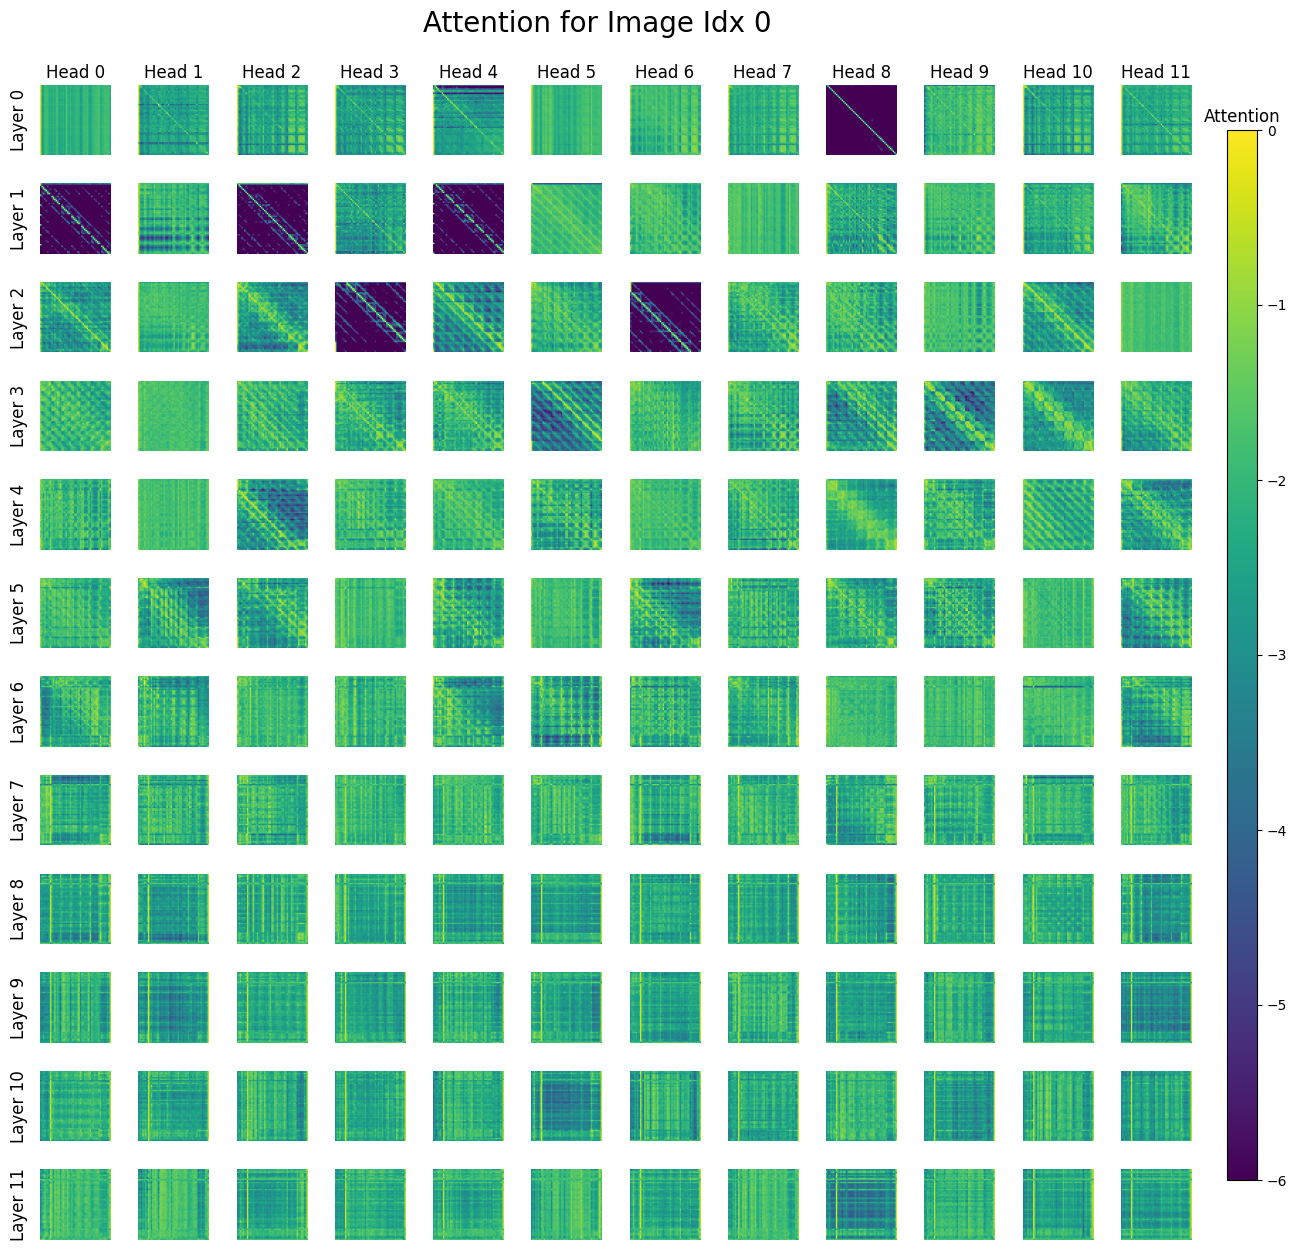

In [11]:
plot_attn_heads(all_attentions, global_min_max=True, figsize=(15,15), global_normalize=False, log_transform=True)

In [12]:
# Aggregate attention patterns across the batch
huge_loader = DataLoader(dataset['test'], batch_size=64, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
huge_data = next(iter(huge_loader))
huge_images, huge_labels = huge_data['image'], huge_data['label']
huge_output, huge_cache = model.run_with_cache(huge_images)

huge_attentions_shape:  (12, 64, 12, 50, 50)
flattened_attentions:  (144, 50, 50)
Total Min: 1.4430424486676066e-32, Total Max: 1.0


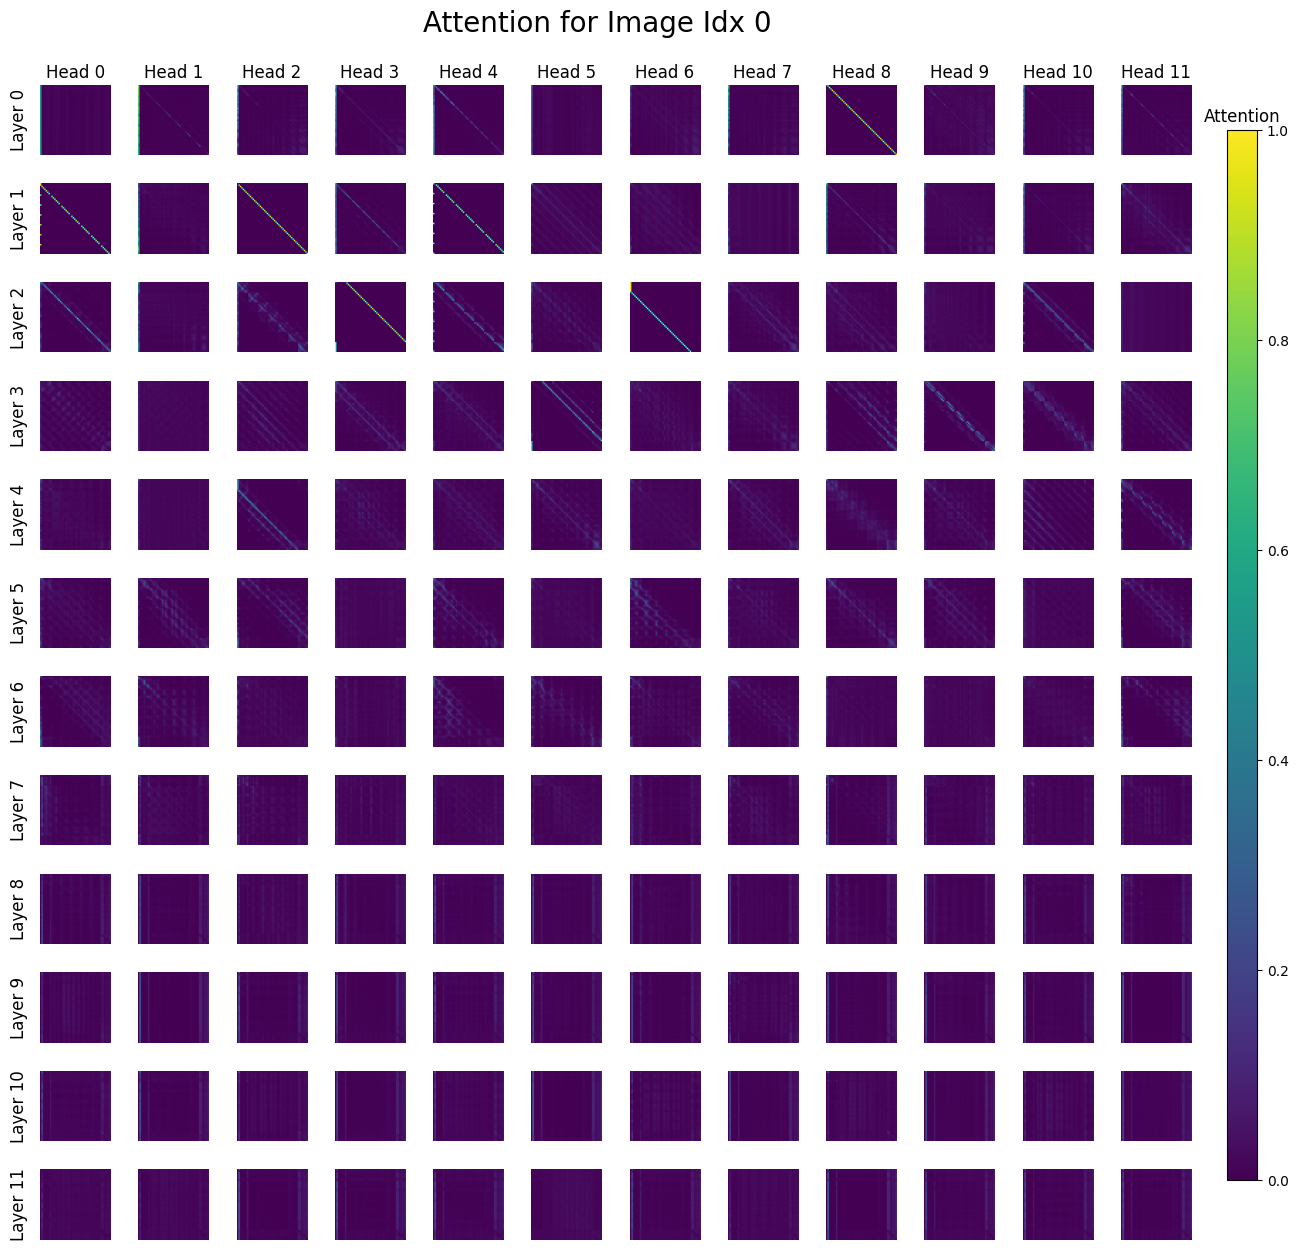

In [13]:
# Aggregate attention patterns across the batch
huge_attentions = [huge_cache['pattern', head_idx] for head_idx in range(12)]
print("huge_attentions_shape: ", np.array(huge_attentions).shape)
# shape = (12, 64, 12, 50, 50)

# Average attention patterns across the batch
aggregated_attentions = torch.stack(huge_attentions).mean(dim=1)
# shape = (12, 12, 50, 50) - averaged across batch size

# Reshape aggregated attentions to match the expected input format
flattened_attentions = aggregated_attentions.view(-1, aggregated_attentions.shape[2], aggregated_attentions.shape[3])
print("flattened_attentions: ", np.array(flattened_attentions).shape)
# shape = (144, 50, 50) - (12 heads * 12 layers, 50, 50)

# Visualize or use the aggregated attention map
plot_attn_heads(flattened_attentions, global_min_max=True, figsize=(15,15), global_normalize=False, log_transform=False)

# Interactive Visualization

Let's examine each attention head more deeply. We'll notice there are attention heads encoding general patterns.

## Corner Head

Let's load the attention scores (pre-softmax) for Head 1.

Each axis of the attention head represents the flattened image. There are 50 patches including the CLS token. The attention head represents every patch's correlation with every other patch. The y-axis is the query, and the x-axis is the key.

For example, the upper left corner of the attention head is the CLS's token correlation with itself. The leftmost column is the CLS token's key correlation with every query. The topmost row is the CLS token's query correlation with every key.

Run your cursor over the attention head and notice the corresponding key/query values on the image itself.

*Note: We'll refer to attention heads with indices 0-144 for all 12 attention heads of all 12 layers.*

In [14]:
from vit_prisma.visualization.visualize_attention_js import plot_javascript
from IPython.display import display, HTML

attn_head_idx = 1
batch_idx = 1
patterns = visualize_attention(attn_head_idx, cache, "Attention Scores", 700, batch_idx = batch_idx, attention_type="attn_scores")
image = images[batch_idx]
html_code = plot_javascript(patterns, [image], ATTN_SCALING=8)

with open("html/corner_head_1_image.html", "w") as f:
    f.write(html_code)

In [15]:
display(HTML(html_code))

For this particular attention head, we can see that there are six key columns that correspond to the corners and midpoints of the image. Run your cursor over each of the six columns, and notice that the pink square stays in a corner/midpoint patch and correlates with every other patch of the image.

Let's check how general this head is. Does it show the same pattern on other datapoints?

Below, we visualize the same attention head on more images. Check out the drop-down menu to toggle between other images in the batch.

In [16]:
# Our plot_javascript function takes in a list of attention heads and list of images
# Let's plot the same attention head for multiple images to validate its generality

# Specify attention head index
attn_head_idx = 1

# Put in list so right format for function
list_of_attn_heads = attn_head_idx
all_patterns = get_attn_across_datapoints(attn_head_idx)

# Put images in right format
list_of_images = [image for image in images] # turn batch tensor into list

# Get html code and display
multiple_html_code = plot_javascript(all_patterns, list_of_images, ATTN_SCALING=8)

with open("html/1hNi.html", "w") as f:
    f.write(multiple_html_code)


**Corner Head Attention Pattern**

Let's plot the post soft-max attention patterns. We can see most of the values go to zero except for the CLS key.

One open question is how to connect our observations about the attention scores (pre-softmax) to the attention pattern (post-softmax).

In [17]:
attn_head_idx = 1
all_patterns = get_attn_across_datapoints(attn_head_idx, attention_type="pattern") # Change attention_type to "pattern" for patterns instead of scores
post_softmax_html_code = plot_javascript(all_patterns, list_of_images, ATTN_SCALING=8)
with open("html/post_softmax.html", "w") as f:
    f.write(post_softmax_html_code)
# display(HTML(html_code))

The attention head appears to capture the corners/midpoints of every image! This is surprisingly geometric.

## Modulus Head

Let's check out some other attention patterns.

This attention head appears to have a modulus-style pattern that is a tesselation of squares. The attention head appears to "know" when the row/column wraps around itself. Run your cursor along the attentention head to check it out. Toggle between images with the drop-down to check if the pattern is general.

In [18]:
attn_head_idx = 3
all_patterns = get_attn_across_datapoints(attn_head_idx)
list_of_images = [image for image in images]
modulus_html_code = plot_javascript(all_patterns, list_of_images, ATTN_SCALING=8)
with open("html/modulus.html", "w") as f:
    f.write(modulus_html_code)
# display(HTML(html_code))

**Modulus Head Attention Pattern**

In [19]:
attn_head_idx = 3
all_patterns = get_attn_across_datapoints(attn_head_idx, attention_type="pattern")
modulus_pattern_html_code = plot_javascript(all_patterns, list_of_images, ATTN_SCALING=8)
with open("html/modulus_pattern.html", "w") as f:
    f.write(modulus_pattern_html_code)

## Edges Head

This attention head seems to suppress most of the image. There is still a vivid geometry in alternating between patches in the key columns, with the lighter columns corresponding to the edges of the image.

In [20]:
attn_head_idx = 40
all_patterns = get_attn_across_datapoints(attn_head_idx, attention_type="attn_scores")
edge_html_code = plot_javascript(all_patterns, list_of_images, ATTN_SCALING=8)
with open("html/edges.html", "w") as f:
    f.write(edge_html_code)
# display(HTML(html_code))

**Edges Head Atention Pattern**

In [21]:
attn_head_idx = 58
all_patterns = get_attn_across_datapoints(attn_head_idx, attention_type="pattern")
edge_pattern_html_code = plot_javascript(all_patterns, list_of_images, ATTN_SCALING=8)
with open("html/58.html", "w") as f:
    f.write(edge_pattern_html_code)

In [22]:
attn_head_idx = 58
all_patterns = get_attn_across_datapoints(attn_head_idx, attention_type="attn_scores")
edge_html_code = plot_javascript(all_patterns, list_of_images, ATTN_SCALING=8)
with open("html/58_pattern.html", "w") as f:
    f.write(edge_html_code)
# display(HTML(html_code))

# Comments

## Questions for the reader
* How do we connect our observations of the attention score (pre-softmax) to the attention scores?
* What other general heads exist? What general heads exist in later layers? Try the code on a variety of images, inspect later layers

## More notebooks
* [Emoji Logit Lens Demo](https://colab.research.google.com/drive/1yAHrEoIgkaVqdWC4GY-GQ46ZCnorkIVo)
* [Interactive Attention Head Demo](https://colab.research.google.com/drive/1P252fCvTHNL_yhqJDeDVOXKCzIgIuAz2)

See the [Prisma repo](https://github.com/soniajoseph/ViT-Prisma/tree/main) for the original codebase.
